# Model selection example for polynomials

In this notebook we will have a glimpse at a model selection example for polynomials. For that we will run Gaussian process quadrature on the polynomial randomly roled in the notebook 'GPQ on low-order polynomials' for many different $b$-values and see what is the most fitting by comparing the results.

In [1]:
import numpy as np
import scipy as sp
import GPy
import kernels
import functions
from matplotlib import pyplot as plt

rng = np.random.default_rng(420)
length = rng.integers(low=1, high=16, size=1)
coeff = rng.random((length[0],))

def poly(x):
    temp = 0
    for i in range(0, len(coeff)):
        temp = temp + coeff[i] * np.power(x, i)
    return temp

In [2]:
b = np.linspace(0.01, 0.99, 99)
integralvalues = np.zeros((6, len(b)))
varvalues = np.zeros((6, len(b)))
abs_err = np.zeros((6, len(b)))
rel_err = np.zeros((6, len(b)))

I_poly = sp.integrate.quad(poly, a=-1, b=1, epsabs=1.49e-16)[0]

for k in range(2, 8):
    for i in range(0, len(b)):
        PBK = kernels.PolynomialBasis(input_dim=1, weight=b[i])
        GPQ = functions.GPQ(f=poly, kernel=PBK, A=np.array([-1, 1]), NoN=k, return_var=True)
        integralvalues[k-2][i] = GPQ[0]
        varvalues[k-2][i] = GPQ[1]
        abs_err[k-2][i] = np.absolute(integralvalues[k-2][i] - I_poly)
        rel_err[k-2][i] = abs_err[k-2][i] / np.absolute(I_poly)

## Plotting & comparing the results

First we will plot the results by plotting the absolute/relative error against the $b$-values used in the GPQ. Than we will numerically find out the best $b$-value.

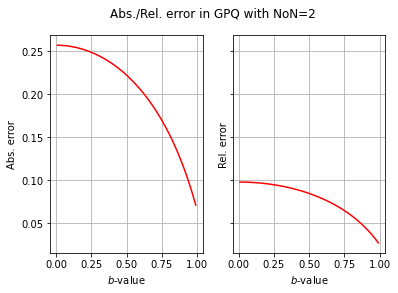

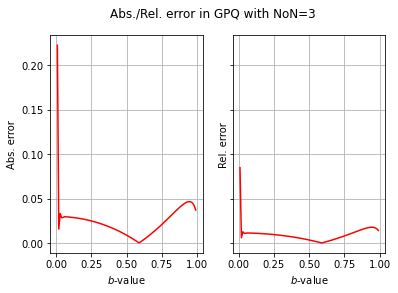

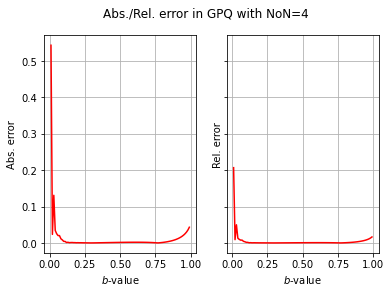

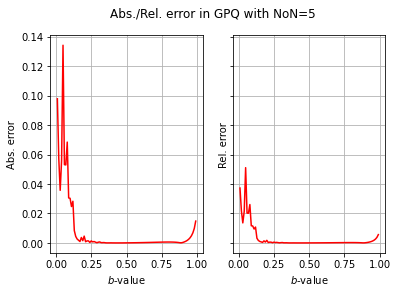

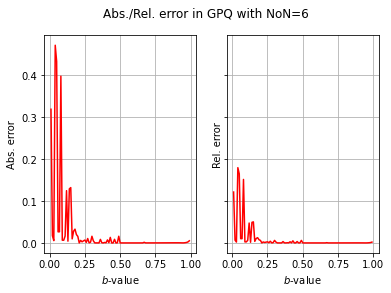

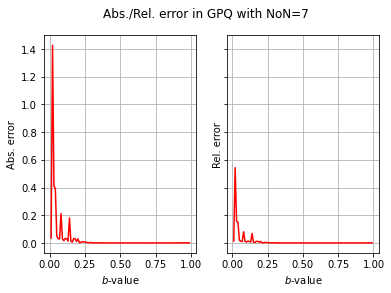

In [3]:
for k in range(2, 8):
    fig, (ax1, ax2) = plt.subplots(1, 2, sharex=True, sharey=True)
    fig.suptitle('Abs./Rel. error in GPQ with NoN=' + '{}'.format(k))
    ax1.plot(b, abs_err[k-2], 'r')
    ax1.grid()
    ax1.set_xlabel('$b$-value')
    ax1.set_ylabel('Abs. error')
    ax2.plot(b, rel_err[k-2], 'r')
    ax2.set_xlabel('$b$-value')
    ax2.set_ylabel('Rel. error')
    ax2.grid()

Now we will calculate the best $b$-value for the different number of nodes:

In [4]:
best_abs = np.zeros(6)
best_rel = np.zeros(6)
for k in range(2, 8):
    best_abs[k-2] = (np.argmin(abs_err[k-2]) + 1) / 100
    best_rel[k-2] = (np.argmin(rel_err[k-2]) + 1) / 100

In [5]:
print('Best $b$-value for abs. error:')
print(best_abs)
print('Best $b$-value for rel. error:')
print(best_rel)

Best $b$-value for abs. error:
[0.99 0.59 0.29 0.44 0.54 0.58]
Best $b$-value for rel. error:
[0.99 0.59 0.29 0.44 0.54 0.58]


## Model selection for arbitrary polynomials of specific degree

In this section we will investigate the connection between the $b$-values and the degree of the given polynomials. For that we will first have a collection of simple monomials and see which $b$-value of fitting for them.

In [6]:
A = np.array([-1, 1])
NoF = 11
int_value_GPQ = np.zeros((6, NoF, len(b)))
I_ex = np.zeros(NoF)
abs_err_GPQ = np.zeros((6, NoF, len(b)))
rel_err_GPQ = np.zeros((6, NoF, len(b)))


for k in range(2, 8):
    for t in range(0, NoF):
        def func(x):
            return np.power(x, t) + 1
        if k == 2: I_ex[t] = sp.integrate.quad(func, a=-1, b=1, epsabs=1.49e-16)[0]
        for i in range(0, len(b)):
            PBK = kernels.PolynomialBasis(input_dim=1, weight=b[i])
            int_value_GPQ[k-2][t][i] = functions.GPQ(f=func, kernel=PBK, A=A, NoN=k, return_var=False)
            abs_err_GPQ[k-2][t][i] = np.absolute(int_value_GPQ[k-2][t][i] - I_ex[t])
            rel_err_GPQ[k-2][t][i] = abs_err_GPQ[k-2][t][i] / np.absolute(I_ex[t])

### Plotting the results

In [7]:
b_opt_abs = np.zeros((6, NoF))
b_opt_rel = np.zeros((6, NoF))

for k in range(2, 8):
    for t in range(0, NoF):
        b_opt_abs[k-2][t] = (np.argmin(abs_err_GPQ[k-2][t]) + 1) / 100
        b_opt_rel[k-2][t] = (np.argmin(rel_err_GPQ[k-2][t]) + 1) / 100

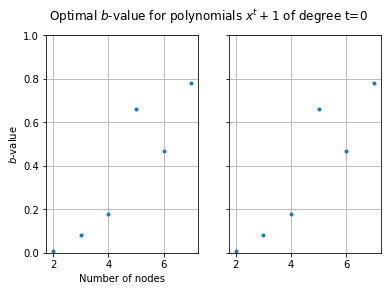

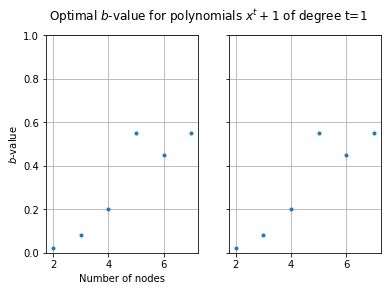

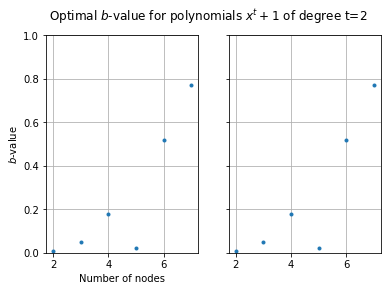

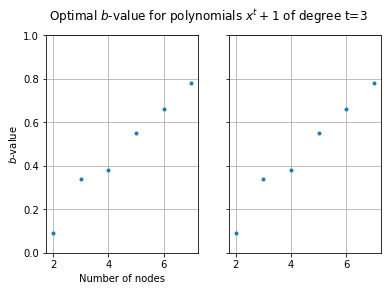

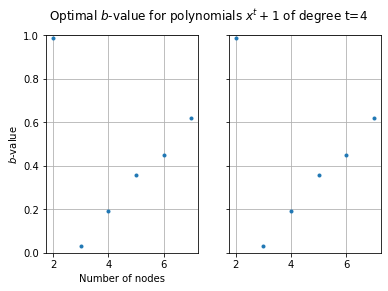

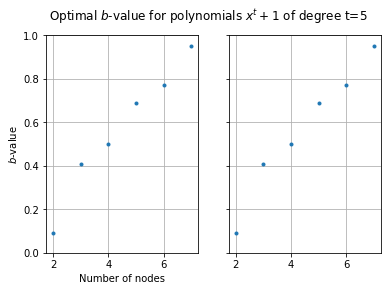

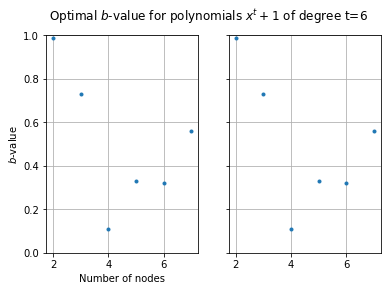

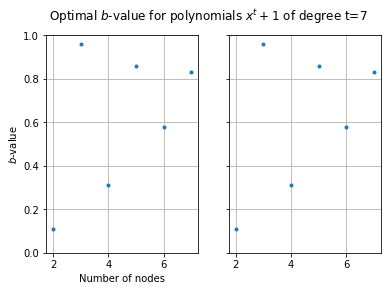

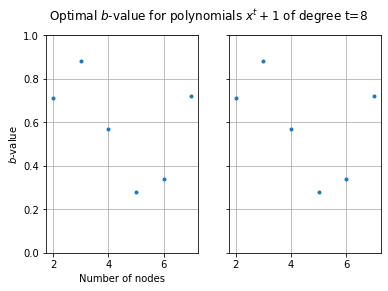

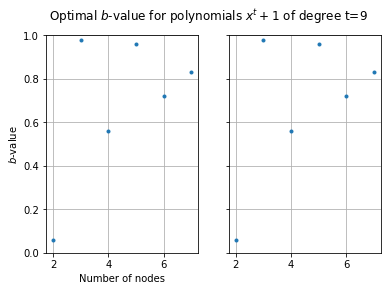

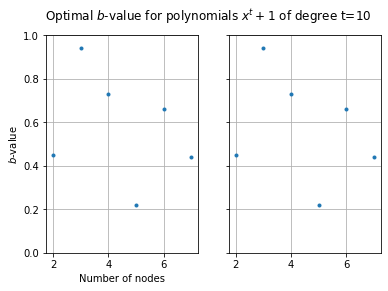

In [8]:
NoN = np.arange(2, 8, 1)
for t in range(0, NoF):
    fig, (ax1, ax2) = plt.subplots(1, 2, sharex=True, sharey=True)
    ax1.grid()
    ax2.grid()
    fig.suptitle('Optimal $b$-value for polynomials $x^t + 1$ of degree t=' + '{}'.format(t))
    ax1.plot(NoN, b_opt_abs.T[t], '.')
    ax2.plot(NoN, b_opt_rel.T[t], '.')
    ax1.set_xlabel('Number of nodes')
    ax1.set_ylabel('$b$-value')
    plt.ylim(0, 1)
    plt.show()

Now we will look at more sophisticated polynomials. For that we will have 100 polynomials of degree $t=0,\ldots, 10$ and do the same as we did above such that we will have a distribution over optimal $b$-values. For this huge investigation we will look at the polynomial degrees seperately.

### Degree 10

In [9]:
b = np.linspace(0.01, 0.99, 99)
NoF_10 = 100
I_10 = np.zeros(NoF_10)
int_value_10 = np.zeros((6, NoF_10, len(b)))
abs_err_10 = np.zeros((6, NoF_10, len(b)))
rel_err_10 = np.zeros((6, NoF_10, len(b)))
c = 1
a = -1
order = 10

for k in range(2, 8):
    for t in range(0, NoF_10):
        rng = np.random.default_rng(t)
        coeff = (c-a) * rng.random((order + 1,)) + a
        def func(x):
            temp = 0
            for u in range(0, len(coeff)):
                temp = temp + coeff[u] * np.power(x, u)
            return temp
        if k == 2: I_10[t] = sp.integrate.quad(func, a=-1, b=1, epsabs=1.49e-16)[0]
        for i in range(0, len(b)):
            PBK = kernels.PolynomialBasis(input_dim=1, weight=b[i])
            int_value_10[k-2][t][i] = functions.GPQ(f=func, kernel=PBK, A=A, NoN=k, return_var=False)
            abs_err_10[k-2][t][i] = np.absolute(int_value_10[k-2][t][i] - I_10[t])
            rel_err_10[k-2][t][i] = abs_err_10[k-2][t][i] / np.absolute(I_10[t])
            
b_opt_abs_10 = np.zeros((6, NoF_10))
b_opt_rel_10 = np.zeros((6, NoF_10))
for k in range(2, 8):
    for t in range(0, NoF_10):
        b_opt_abs_10[k-2][t] = (np.argmin(abs_err_10[k-2][t]) + 1) / 100
        b_opt_rel_10[k-2][t] = (np.argmin(rel_err_10[k-2][t]) + 1) / 100
        
b_vis_abs_10 = [b_opt_abs_10[0], b_opt_abs_10[1], b_opt_abs_10[2], b_opt_abs_10[3], b_opt_abs_10[4], b_opt_abs_10[5]]
b_vis_rel_10 = [b_opt_rel_10[0], b_opt_rel_10[1], b_opt_rel_10[2], b_opt_rel_10[3], b_opt_rel_10[4], b_opt_rel_10[5]]
pos = [2, 3, 4, 5, 6, 7]

In [10]:
b_opt_abs_10.T

array([[0.01, 0.77, 0.8 , 0.46, 0.65, 0.78],
       [0.01, 0.86, 0.6 , 0.48, 0.45, 0.57],
       [0.01, 0.78, 0.3 , 0.22, 0.31, 0.53],
       [0.01, 0.03, 0.19, 0.64, 0.79, 0.63],
       [0.99, 0.92, 0.63, 0.4 , 0.58, 0.62],
       [0.99, 0.65, 0.35, 0.72, 0.88, 0.54],
       [0.99, 0.02, 0.73, 0.28, 0.69, 0.52],
       [0.99, 0.64, 0.5 , 0.3 , 0.96, 0.43],
       [0.68, 0.99, 0.62, 0.37, 0.53, 0.47],
       [0.69, 0.99, 0.08, 0.85, 0.35, 0.69],
       [0.99, 0.96, 0.69, 0.51, 0.73, 0.75],
       [0.99, 0.02, 0.62, 0.82, 0.92, 0.49],
       [0.02, 0.02, 0.89, 0.53, 0.72, 0.73],
       [0.99, 0.02, 0.1 , 0.61, 0.45, 0.44],
       [0.99, 0.85, 0.66, 0.8 , 0.76, 0.77],
       [0.03, 0.83, 0.68, 0.5 , 0.73, 0.56],
       [0.92, 0.98, 0.7 , 0.39, 0.45, 0.84],
       [0.99, 0.63, 0.11, 0.58, 0.77, 0.52],
       [0.99, 0.02, 0.68, 0.44, 0.63, 0.79],
       [0.01, 0.91, 0.68, 0.54, 0.79, 0.91],
       [0.71, 0.95, 0.79, 0.93, 0.53, 0.59],
       [0.95, 0.48, 0.9 , 0.98, 0.84, 0.85],
       [0.

In [11]:
best_b_10 = np.zeros(6)
for k in range(2, 8):
    median = np.median(sorted(b_opt_abs_10[k-2]))
    mean = np.mean(sorted(b_opt_abs_10[k-2]))
    best_b_10[k-2] = np.round((median + mean) / 2, decimals=2)

best_b_10

array([0.72, 0.75, 0.66, 0.48, 0.61, 0.65])

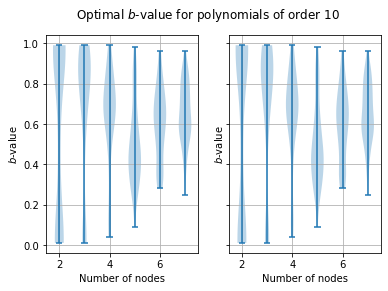

In [12]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, sharey=True, sharex=True)
ax1.grid()
ax2.grid()
ax1.violinplot(b_vis_abs_10, positions=pos)
ax2.violinplot(b_vis_rel_10, positions=pos)
ax1.set_ylabel('$b$-value')
ax1.set_xlabel('Number of nodes')
ax2.set_ylabel('$b$-value')
ax2.set_xlabel('Number of nodes')
fig.suptitle('Optimal $b$-value for polynomials of order 10')
plt.show()

### Degree 16

In [13]:
b = np.linspace(0.01, 0.99, 99)
NoF_16 = 100
I_16 = np.zeros(NoF_16)
int_value_16 = np.zeros((6, NoF_16, len(b)))
abs_err_16 = np.zeros((6, NoF_16, len(b)))
rel_err_16 = np.zeros((6, NoF_16, len(b)))
c = 1
a = -1
order = 16

for k in range(2, 8):
    for t in range(0, NoF_16):
        rng = np.random.default_rng(t)
        coeff = (c-a) * rng.random((order + 1,)) + a
        def func(x):
            temp = 0
            for u in range(0, len(coeff)):
                temp = temp + coeff[u] * np.power(x, u)
            return temp
        if k == 2: I_16[t] = sp.integrate.quad(func, a=-1, b=1, epsabs=1.49e-16)[0]
        for i in range(0, len(b)):
            PBK = kernels.PolynomialBasis(input_dim=1, weight=b[i])
            int_value_16[k-2][t][i] = functions.GPQ(f=func, kernel=PBK, A=A, NoN=k, return_var=False)
            abs_err_16[k-2][t][i] = np.absolute(int_value_16[k-2][t][i] - I_16[t])
            rel_err_16[k-2][t][i] = abs_err_16[k-2][t][i] / np.absolute(I_16[t])
            
b_opt_abs_16 = np.zeros((6, NoF_16))
b_opt_rel_16 = np.zeros((6, NoF_16))
for k in range(2, 8):
    for t in range(0, NoF_16):
        b_opt_abs_16[k-2][t] = (np.argmin(abs_err_16[k-2][t]) + 1) / 100
        b_opt_rel_16[k-2][t] = (np.argmin(rel_err_16[k-2][t]) + 1) / 100
        
b_vis_abs_16 = [b_opt_abs_16[0], b_opt_abs_16[1], b_opt_abs_16[2], b_opt_abs_16[3], b_opt_abs_16[4], b_opt_abs_16[5]]
b_vis_rel_16 = [b_opt_rel_16[0], b_opt_rel_16[1], b_opt_rel_16[2], b_opt_rel_16[3], b_opt_rel_16[4], b_opt_rel_16[5]]
pos = [2, 3, 4, 5, 6, 7]

In [14]:
b_opt_abs_16.T

array([[0.01, 0.92, 0.88, 0.7 , 0.83, 0.88],
       [0.34, 0.02, 0.92, 0.74, 0.49, 0.67],
       [0.01, 0.03, 0.93, 0.76, 0.64, 0.75],
       [0.01, 0.03, 0.08, 0.75, 0.52, 0.8 ],
       [0.99, 0.99, 0.83, 0.74, 0.32, 0.73],
       [0.99, 0.19, 0.84, 0.7 , 0.86, 0.69],
       [0.01, 0.99, 0.81, 0.69, 0.8 , 0.58],
       [0.99, 0.05, 0.89, 0.79, 0.7 , 0.47],
       [0.79, 0.99, 0.71, 0.61, 0.9 , 0.77],
       [0.02, 0.98, 0.7 , 0.4 , 0.47, 0.58],
       [0.99, 0.02, 0.6 , 0.86, 0.73, 0.75],
       [0.99, 0.15, 0.27, 0.79, 0.91, 0.8 ],
       [0.99, 0.01, 0.86, 0.62, 0.44, 0.5 ],
       [0.99, 0.05, 0.13, 0.39, 0.71, 0.66],
       [0.99, 0.55, 0.93, 0.8 , 0.66, 0.73],
       [0.03, 0.03, 0.9 , 0.75, 0.59, 0.73],
       [0.63, 0.83, 0.12, 0.83, 0.6 , 0.75],
       [0.99, 0.61, 0.15, 0.17, 0.68, 0.83],
       [0.99, 0.93, 0.05, 0.73, 0.56, 0.69],
       [0.01, 0.92, 0.73, 0.62, 0.85, 0.92],
       [0.96, 0.91, 0.78, 0.63, 0.93, 0.94],
       [0.99, 0.97, 0.76, 0.28, 0.75, 0.68],
       [0.

In [15]:
best_b_16 = np.zeros(6)
for k in range(2, 8):
    median = np.median(sorted(b_opt_abs_16[k-2]))
    mean = np.mean(sorted(b_opt_abs_16[k-2]))
    best_b_16[k-2] = np.round((median + mean) / 2, decimals=2)
    
best_b_16

array([0.72, 0.78, 0.75, 0.69, 0.68, 0.73])

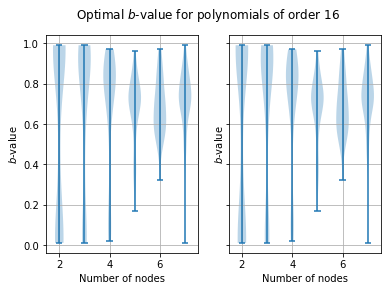

In [16]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, sharey=True, sharex=True)
ax1.grid()
ax2.grid()
ax1.violinplot(b_vis_abs_16, positions=pos)
ax2.violinplot(b_vis_rel_16, positions=pos)
ax1.set_ylabel('$b$-value')
ax1.set_xlabel('Number of nodes')
ax2.set_ylabel('$b$-value')
ax2.set_xlabel('Number of nodes')
fig.suptitle('Optimal $b$-value for polynomials of order 16')
plt.show()

### Degree 25

In [17]:
b = np.linspace(0.01, 0.99, 99)
NoF_25 = 100
I_25 = np.zeros(NoF_25)
int_value_25 = np.zeros((6, NoF_25, len(b)))
abs_err_25 = np.zeros((6, NoF_25, len(b)))
rel_err_25 = np.zeros((6, NoF_25, len(b)))
c = 1
a = -1
order = 25

for k in range(2, 8):
    for t in range(0, NoF_25):
        rng = np.random.default_rng(t)
        coeff = (c-a) * rng.random((order + 1,)) + a
        def func(x):
            temp = 0
            for u in range(0, len(coeff)):
                temp = temp + coeff[u] * np.power(x, u)
            return temp
        if k == 2: I_25[t] = sp.integrate.quad(func, a=-1, b=1, epsabs=1.49e-16)[0]
        for i in range(0, len(b)):
            PBK = kernels.PolynomialBasis(input_dim=1, weight=b[i])
            int_value_25[k-2][t][i] = functions.GPQ(f=func, kernel=PBK, A=A, NoN=k, return_var=False)
            abs_err_25[k-2][t][i] = np.absolute(int_value_25[k-2][t][i] - I_25[t])
            rel_err_25[k-2][t][i] = abs_err_25[k-2][t][i] / np.absolute(I_25[t])
            
b_opt_abs_25 = np.zeros((6, NoF_25))
b_opt_rel_25 = np.zeros((6, NoF_25))
for k in range(2, 8):
    for t in range(0, NoF_25):
        b_opt_abs_25[k-2][t] = (np.argmin(abs_err_25[k-2][t]) + 1) / 100
        b_opt_rel_25[k-2][t] = (np.argmin(rel_err_25[k-2][t]) + 1) / 100
        
b_vis_abs_25 = [b_opt_abs_25[0], b_opt_abs_25[1], b_opt_abs_25[2], b_opt_abs_25[3], b_opt_abs_25[4], b_opt_abs_25[5]]
b_vis_rel_25 = [b_opt_rel_25[0], b_opt_rel_25[1], b_opt_rel_25[2], b_opt_rel_25[3], b_opt_rel_25[4], b_opt_rel_25[5]]
pos = [2, 3, 4, 5, 6, 7]

In [18]:
b_opt_abs_25.T

array([[0.01, 0.88, 0.81, 0.56, 0.74, 0.59],
       [0.01, 0.05, 0.71, 0.97, 0.84, 0.77],
       [0.01, 0.07, 0.93, 0.76, 0.66, 0.79],
       [0.01, 0.65, 0.08, 0.73, 0.53, 0.8 ],
       [0.99, 0.99, 0.85, 0.8 , 0.9 , 0.82],
       [0.87, 0.02, 0.92, 0.85, 0.77, 0.73],
       [0.9 , 0.99, 0.66, 0.89, 0.77, 0.76],
       [0.99, 0.79, 0.05, 0.93, 0.83, 0.45],
       [0.77, 0.99, 0.8 , 0.32, 0.87, 0.77],
       [0.68, 0.82, 0.11, 0.39, 0.8 , 0.74],
       [0.58, 0.99, 0.97, 0.85, 0.74, 0.77],
       [0.79, 0.99, 0.88, 0.84, 0.74, 0.86],
       [0.99, 0.99, 0.87, 0.69, 0.71, 0.88],
       [0.74, 0.02, 0.92, 0.94, 0.78, 0.77],
       [0.99, 0.99, 0.97, 0.9 , 0.97, 0.89],
       [0.03, 0.03, 0.1 , 0.59, 0.87, 0.77],
       [0.45, 0.75, 0.02, 0.79, 0.92, 0.76],
       [0.99, 0.01, 0.88, 0.51, 0.86, 0.79],
       [0.99, 0.97, 0.98, 0.2 , 0.78, 0.8 ],
       [0.01, 0.96, 0.89, 0.23, 0.84, 0.78],
       [0.97, 0.92, 0.46, 0.93, 0.88, 0.71],
       [0.99, 0.97, 0.75, 0.93, 0.83, 0.73],
       [0.

In [19]:
best_b_25 = np.zeros(6)
for k in range(2, 8):
    median = np.median(sorted(b_opt_abs_25[k-2]))
    mean = np.mean(sorted(b_opt_abs_25[k-2]))
    best_b_25[k-2] = np.round((median + mean) / 2, decimals=2)
    
best_b_25

array([0.75, 0.84, 0.81, 0.8 , 0.81, 0.77])

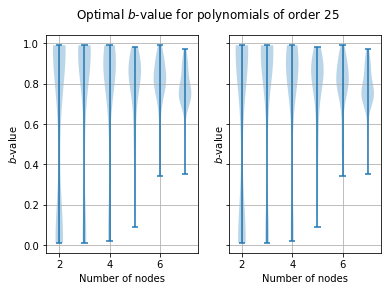

In [20]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, sharey=True, sharex=True)
ax1.grid()
ax2.grid()
ax1.violinplot(b_vis_abs_25, positions=pos)
ax2.violinplot(b_vis_rel_25, positions=pos)
ax1.set_ylabel('$b$-value')
ax1.set_xlabel('Number of nodes')
ax2.set_ylabel('$b$-value')
ax2.set_xlabel('Number of nodes')
fig.suptitle('Optimal $b$-value for polynomials of order 25')
plt.show()

### All in one figure

In [21]:
import matplotlib
matplotlib.rc('xtick', labelsize=20) 
matplotlib.rc('ytick', labelsize=20) 

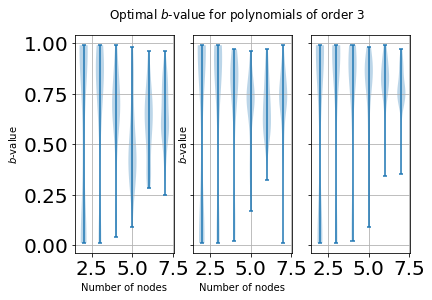

In [22]:
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, sharey=True, sharex=True)
ax1.grid()
ax2.grid()
ax3.grid()
ax1.violinplot(b_vis_rel_10, positions=pos)
ax2.violinplot(b_vis_rel_16, positions=pos)
ax3.violinplot(b_vis_rel_25, positions=pos)
ax1.set_ylabel('$b$-value')
ax1.set_xlabel('Number of nodes')
ax2.set_ylabel('$b$-value')
ax2.set_xlabel('Number of nodes')
fig.suptitle('Optimal $b$-value for polynomials of order 3')
plt.show()

In [23]:
best_b_10

array([0.72, 0.75, 0.66, 0.48, 0.61, 0.65])

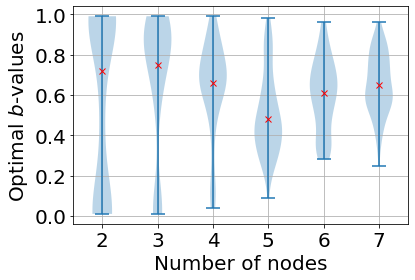

In [24]:
plt.figure()
plt.violinplot(b_vis_rel_10, positions=pos)
plt.grid()
#plt.title('Polynomials of degree 10', fontsize=20)
plt.ylabel('Optimal $b$-values', fontsize=20)
plt.xlabel('Number of nodes', fontsize=20)
plt.plot(pos, best_b_10, 'rx')
plt.yticks([0, 0.2, 0.4, 0.6, 0.8, 1])
plt.xticks([2, 3, 4, 5, 6, 7])
plt.show()

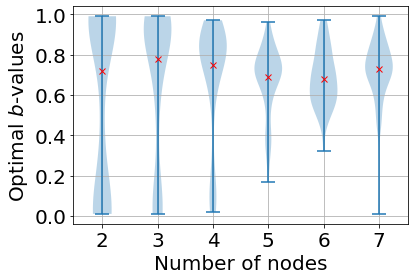

In [25]:
plt.figure()
plt.violinplot(b_vis_rel_16, positions=pos)
plt.grid()
#plt.title('Polynomials of degree 16', fontsize=20)
plt.ylabel('Optimal $b$-values', fontsize=20)
plt.xlabel('Number of nodes', fontsize=20)
plt.plot(pos, best_b_16, 'rx')
plt.yticks([0, 0.2, 0.4, 0.6, 0.8, 1])
plt.xticks([2, 3, 4, 5, 6, 7])
plt.show()

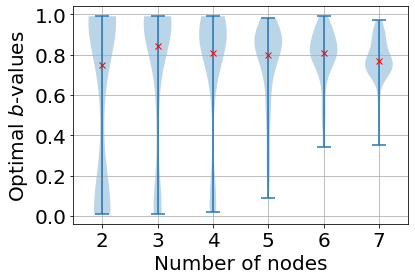

In [26]:
plt.figure()
plt.violinplot(b_vis_rel_25, positions=pos)
plt.grid()
#plt.title('Polynomials of degree 25', fontsize=20)
plt.ylabel('Optimal $b$-values', fontsize=20)
plt.xlabel('Number of nodes', fontsize=20)
plt.plot(pos, best_b_25, 'rx')
plt.yticks([0, 0.2, 0.4, 0.6, 0.8, 1])
plt.xticks([2, 3, 4, 5, 6, 7])
plt.show()